In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [158]:
intervals = pd.read_csv("543449_intervals.csv")
intervals.START_TS = pd.to_datetime(intervals.START_TS)

Epoch: 0, loss: 0.79097
Epoch: 100, loss: 0.01804
Epoch: 200, loss: 0.01686
Epoch: 300, loss: 0.01564
Epoch: 400, loss: 0.01454
Epoch: 500, loss: 0.01380
Epoch: 600, loss: 0.01349
Epoch: 700, loss: 0.01331
Epoch: 800, loss: 0.01307
Epoch: 900, loss: 0.01282
Epoch: 1000, loss: 0.01266
Epoch: 1100, loss: 0.01253
Epoch: 1200, loss: 0.01241
Epoch: 1300, loss: 0.01229
Epoch: 1400, loss: 0.01217
Epoch: 1500, loss: 0.01206
Epoch: 1600, loss: 0.01195
Epoch: 1700, loss: 0.01184


No handles with labels found to put in legend.


Epoch: 1800, loss: 0.01174
Epoch: 1900, loss: 0.01164


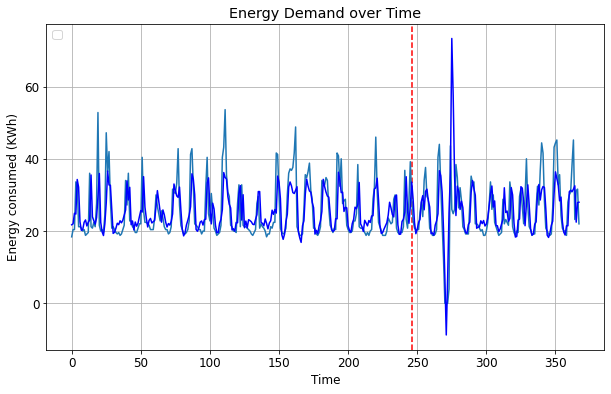

In [159]:
df = intervals[(intervals.START_TS >= '2020-01-01') & (intervals.START_TS <= '2020-02-01')]
df.index = df.START_TS
df= df.resample("2h").sum()

training_set = df
training_set = df.iloc[:,1:2].values

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out
    

num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 5
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)



plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Time')
ax.set_ylabel('Energy consumed (KWh)')
ax.set_title('Energy Demand over Time')
ax.grid(True)

plt.axvline(x=train_size, c='r', linestyle='--')
plt.plot(dataY_plot)
plt.plot(data_predict, c='b')
plt.legend(loc='upper left')
plt.show()

No handles with labels found to put in legend.


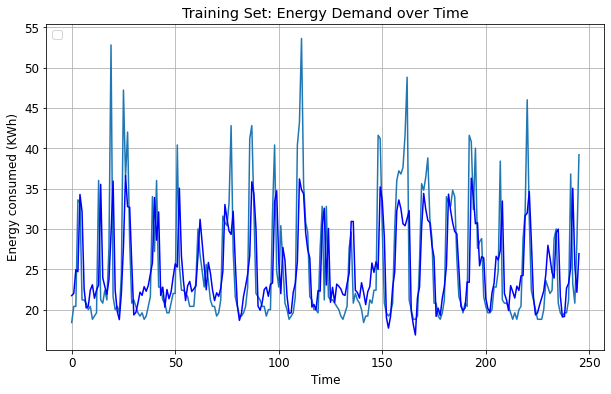

In [160]:
lstm.eval()
train_predict = lstm(trainX)

data_predict = train_predict.data.numpy()
dataY_plot = trainY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)



plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Time')
ax.set_ylabel('Energy consumed (KWh)')
ax.set_title('Training Set: Energy Demand over Time')
ax.grid(True)

plt.plot(dataY_plot)
plt.plot(data_predict, c='b')
plt.legend(loc='upper left')
plt.show()

No handles with labels found to put in legend.


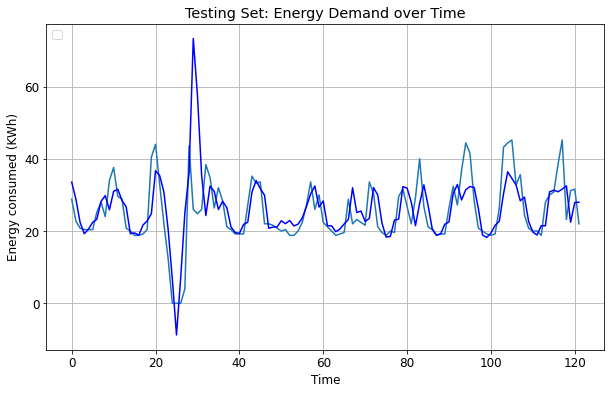

In [161]:
lstm.eval()
train_predict = lstm(testX)

data_predict = train_predict.data.numpy()
dataY_plot = testY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)



plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Time')
ax.set_ylabel('Energy consumed (KWh)')
ax.set_title('Testing Set: Energy Demand over Time')
ax.grid(True)

plt.plot(dataY_plot)
plt.plot(data_predict, c='b')
plt.legend(loc='upper left')
plt.show()